In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cdv-healthcare-data/cvd-healthcare-data.xlsx


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import os, math
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix

In [4]:
dfMerge = pd.read_excel('/kaggle/input/cdv-healthcare-data/cvd-healthcare-data.xlsx')
dfMerge

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [5]:
dfMerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
dfMerge.target.unique()

array([1, 0])

In [13]:
def create_data(dfMerge):
    X = np.array(dfMerge.iloc[:, 0:-1])
    y = np.asarray(dfMerge['target']).astype('int64')
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)
    
    return train_ds, test_ds

train_ds, test_ds = create_data(dfMerge)

In [7]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output

In [9]:
class ResMLP(tf.keras.Model):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2
        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [16]:
net = ResMLP(initial_filters=16, block_list=[2, 2, 2], num_classes=2)

net.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

history = net.fit(train_ds, epochs=30, batch_size=8, validation_data=test_ds)

net.summary()

Epoch 1/30
29/29 [==============================] - 3s 20ms/step - loss: 0.5572 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.5664 - val_sparse_categorical_accuracy: 0.7237
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.3830 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.5244 - val_sparse_categorical_accuracy: 0.7105
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.3262 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.5410 - val_sparse_categorical_accuracy: 0.7368
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2980 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.5149 - val_sparse_categorical_accuracy: 0.7368
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.4726 - val_sparse_categorical_accuracy: 0.7763
Epoch 6/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2329 - sparse_categorical_accuracy:

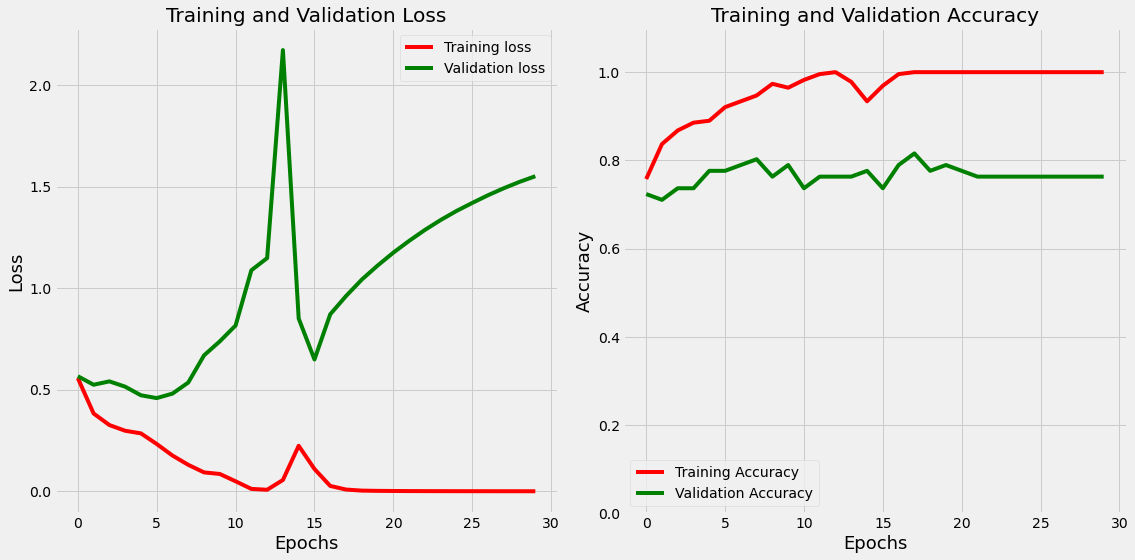

In [19]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['sparse_categorical_accuracy']
    tloss = history.history['loss']

    vacc = history.history['val_sparse_categorical_accuracy']
    vloss = history.history['val_loss']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(history, epochs=30)

there were 18 errors in 76 tests for an accuracy of  76.32%


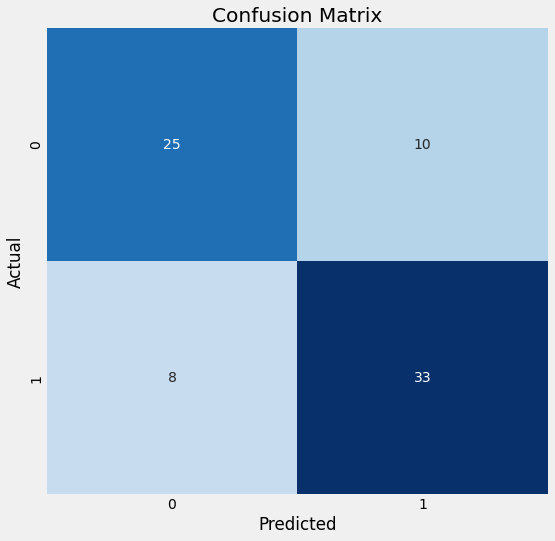

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.7576    0.7143    0.7353        35
           1     0.7674    0.8049    0.7857        41

    accuracy                         0.7632        76
   macro avg     0.7625    0.7596    0.7605        76
weighted avg     0.7629    0.7632    0.7625        76



In [20]:
def predictor(test_ds):
    y_pred = []
    y_true = []
    errors = 0
    for X_test, y_test in test_ds:
        pred = tf.argmax(net.predict(X_test), axis=1)
        for i in range(len(pred)):
            pred_index = pred[i]
            true_index = y_test[i]
            if pred_index != true_index:
                errors += 1
            y_pred.append(pred_index)
            y_true.append(true_index)
            
    acc = (1 - errors / len(y_true)) * 100
    msg = f'there were {errors} errors in {len(y_true)} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if len(set(ytrue)) <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, f1score

errors, f1score = predictor(test_ds)